In [11]:
from tqdm import tqdm
import random
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2, ToTensor
from torchvision.models import resnet18

In [12]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToTensor()
])

In [13]:
train_dataset = datasets.CIFAR100(
    root="./nodes/data",
    download=False,
    train=True,
    transform=transforms
)


test_dataset = datasets.CIFAR100(
    root="./nodes/data",
    download=False,
    train=False, 
    transform=ToTensor()
)

In [14]:
batch_size = 32
epochs = 20
learning_rate = 1e-3
weight_decay = 1e-4

In [15]:
val_size = len(test_dataset) // 2
val_dataset = torch.utils.data.Subset(test_dataset, range(val_size))
test_dataset = torch.utils.data.Subset(test_dataset, range(val_size, len(test_dataset)))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=val_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
class Classifier(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()

        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier(num_classes=100).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3)

In [18]:
def train():
    model.train()
    losses = []
    model.train()
    for b, (X, y) in tqdm(enumerate(train_dataloader)):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    return sum(losses)/len(losses)

In [19]:
def validate():
    model.eval()
    with torch.no_grad():
        X, y = next(iter(val_dataloader))
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
    return loss.item()

In [20]:
train_losses = []
val_losses = []
for e in range(epochs):
    loss = train()
    train_losses.append(loss)
    val_loss = validate()
    val_losses.append(val_loss)
    scheduler.step(val_loss)

1563it [00:58, 26.89it/s]
1563it [00:52, 29.59it/s]
1563it [00:52, 29.91it/s]
1563it [00:52, 29.71it/s]
1563it [00:52, 29.83it/s]
1563it [00:53, 29.37it/s]
1563it [00:52, 29.57it/s]
1563it [00:52, 29.55it/s]
1563it [00:52, 29.54it/s]
1563it [00:53, 29.23it/s]
1563it [00:52, 29.59it/s]
1563it [00:52, 29.50it/s]
1563it [00:53, 29.43it/s]
1563it [00:53, 29.37it/s]
1563it [00:53, 29.38it/s]
1563it [00:52, 29.52it/s]
1563it [00:53, 29.38it/s]
1563it [00:52, 29.61it/s]
1563it [00:52, 29.55it/s]
1563it [00:52, 29.66it/s]


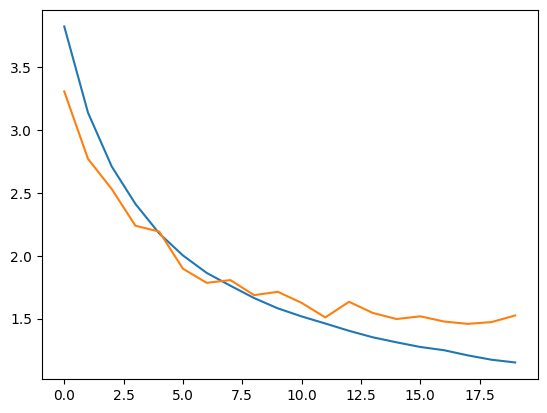

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()